In [44]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug  6 12:47:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    36W / 250W |    419MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [47]:
train = pd.read_csv('/content/drive/MyDrive/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/test_data.csv')

In [48]:
train = train.reindex(np.random.permutation(train.index))# shuffle the train data

In [49]:
test['Label'].value_counts()

1    140000
0     56965
Name: Label, dtype: int64

In [50]:
# last step preprocessing by remove the np.inf value
def RemoveNA_Inf(df): 
  print("Before replacing inf")
  print(np.isinf(df).values.sum())
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  print("After replacing inf")
  print(np.isinf(df).values.sum())
  print(df.isnull().sum())
  df.dropna(axis=0,inplace=True)
  print(df.isnull().sum())
  return df

In [51]:
RemoveNA_Inf(train)

Before replacing inf
604
After replacing inf
0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
                              ..
Idle Std                       0
Idle Max                       0
Idle Min                       0
Inbound                        0
Label                          0
Length: 61, dtype: int64
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
                              ..
Idle Std                       0
Idle Max                       0
Idle Min                       0
Inbound                        0
Label                          0
Length: 61, dtype: int64


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,SYN Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
222813,37600114.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.127653e-01,5.371445e+06,6.736968e+06,13949102.0,0.0,37600114.0,5.371445e+06,6.736968e+06,13949102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.127653e-01,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,160.0,5840.0,-1.0,0.0,20.0,1.0,0.0,1.0,1.0,12533370.0,1231101.8,13949102.0,11714197.0,1.0,1
10818,1.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2208.00,1472.0,0.0,40.0,-1.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
8481,1.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2208.00,1472.0,0.0,-2.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
75924,34713.0,2.0,2.0,166.0,198.0,83.0,83.0,83.0,0.0,99.0,99.0,99.0,0.0,1.048599e+04,1.152306e+02,1.157100e+04,2.003636e+04,34707.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,64.0,5.761530e+01,57.615303,83.0,99.0,89.4,8.763561,76.8,0.0,0.0,0.0,0.0,1.0,111.75,83.0,99.0,64.0,-1.0,-1.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
242096,3000214.0,4.0,0.0,2064.0,0.0,516.0,516.0,516.0,0.0,0.0,0.0,0.0,0.0,6.879509e+02,1.333238e+00,1.000071e+06,1.732173e+06,3000212.0,1.0,3000214.0,1.000071e+06,1.732173e+06,3000212.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333238e+00,0.000000,516.0,516.0,516.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,645.00,516.0,0.0,80.0,-1.0,-1.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61974,1.0,2.0,0.0,1530.0,0.0,765.0,765.0,765.0,0.0,0.0,0.0,0.0,0.0,1.530000e+09,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,0.000000,765.0,765.0,765.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1147.50,765.0,0.0,40.0,-1.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
198523,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,40.0,5840.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
84041,1094.0,200.0,0.0,88000.0,0.0,440.0,440.0,440.0,0.0,0.0,0.0,0.0,0.0,8.043876e+07,1.828154e+05,5.497488e+00,1.314330e+01,53.0,0.0,1094.0,5.497488e+00,1.314330e+01,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.828154e+05,0.000000,440.0,440.0,440.0,0.000000,0.0,0.0,0.0,0.0,0.0,

In [52]:
RemoveNA_Inf(test)

Before replacing inf
13540
After replacing inf
0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
                              ..
Idle Std                       0
Idle Max                       0
Idle Min                       0
Inbound                        0
Label                          0
Length: 61, dtype: int64
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
                              ..
Idle Std                       0
Idle Max                       0
Idle Min                       0
Inbound                        0
Label                          0
Length: 61, dtype: int64


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,SYN Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,0.0,0.000000,0.000000,1.200000e+07,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,2.000000e+06,0.000000,6.0,6.0,6.000000,0.000000,0.000000,0,0,1,1,0.0,9.000000,6.000000,0.000000,40,16560,-1,1,20,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0
1,47,2,0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,0.0,0.000000,0.000000,2.553191e+05,4.255319e+04,4.700000e+01,0.000000e+00,47.0,47.0,47.0,4.700000e+01,0.000000e+00,47.0,47.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,4.255319e+04,0.000000,6.0,6.0,6.000000,0.000000,0.000000,0,0,1,1,0.0,9.000000,6.000000,0.000000,40,238,-1,1,20,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1,0
2,1,2,0,12.0,0.0,6.0,6.0,6.000000,0.000000,0.0,0.0,0.000000,0.000000,1.200000e+07,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,2.000000e+06,0.000000,6.0,6.0,6.000000,0.000000,0.000000,0,0,1,0,0.0,9.000000,6.000000,0.000000,40,16560,-1,1,20,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0
3,8001234,4,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,4.999229e-01,2.667078e+06,4.619513e+06,8001232.0,1.0,8001234.0,2.667078e+06,4.619513e+06,8001232.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,4.999229e-01,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,1,1,0,0.0,0.000000,0.000000,0.000000,128,60720,-1,0,32,1.0,0.000000,1.0,1.0,8001232.0,0.000000e+00,8001232.0,8001232.0,1,0
4,112729696,13,6,368.0,196.0,46.0,6.0,28.307692,19.106651,46.0,6.0,32.666667,20.655911,5.003118e+00,1.685448e-01,6.262761e+06,1.822444e+07,58801719.0,0.0,112729696.0,9.394141e+06,2.193631e+07,58801719.0,1.0,58864181.0,11772836.2,2.632486e+07,58864177.0,0.0,1,120,1.153201e-01,0.053225,6.0,46.0,30.500000,18.980600,360.263158,0,0,1,0,0.0,32.105263,28.307692,32.666667,260,255,253,12,20,62213.0,82.024387,62271.0,62155.0,56301460.5,3.535899e+06,58801719.0,53801202.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196959,109,2,2,12.0,12.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.000000,0.000000,2.201835e+05,3.669725e+04,3.633333e+01,6.206717e+01,108.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,1.0,0.000000e+00,1.0,1.0,0,40,1.834862e+04,18348.623853,6.0,6.0,6.000000,0.000000,0.000000,0,1,0,0,1.0,7.500000,6.000000,6.000000,40,5840,0,1,20,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1,1
196960,102,2,2,12.0,12.0,6.0,6.0,6.000000,0.000000,6.0,6.0,6.000000,0.000000,2.352941e+05,3.921569e+04,3.400000e+01,5.715768e+01,100.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,0.000000e+00,1.0,1.0,0,40,1.960784e+04,19607.843137,6.0,6.0,6.000000,0.000000,0.000000,0,1,0,0,1.0,7.500000,6.000000,6.000000,40,5840,0,1,20,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,1,1
196962,212123,6,0,2088.0,0.0,393.0,321.0,34

In [53]:
from sklearn import preprocessing

In [54]:
x = train.iloc[:, : -1] # Take the features, except the last column, which is the target 
y = train.iloc[:, -1]
x_test = test.iloc[:, : -1]
y_test = test.iloc[:, -1]

In [55]:
# Normalize Value
x_final = preprocessing.MinMaxScaler().fit_transform(x)
x_test_final = preprocessing.MinMaxScaler().fit_transform(x_test)

In [56]:
# Normalize Value
#x_mean = x.mean()
#x_std = x.std()
#x_norm = (x - x_mean)/x_std

#x_test_mean = x_test.mean()
#x_test_std = x_test.std()
#x_test_norm = (x_test - x_test_mean )/x_test_std

In [57]:
# temperory drop 'Flow Bytes/s' 'Flow Packets/s', and wait for further solution
#x_final= x_norm.drop(['Flow Bytes/s','Flow Packets/s'], axis=1)
#x_test_final= x_test_norm.drop(['Flow Bytes/s','Flow Packets/s'], axis=1)

# Build a base model

In [58]:
def plot_curve(hist):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

In [59]:
def create_model(my_learning_rate):
  # initial ANN
  model = Sequential()

# layers
  model.add(Dense(units = 32,  activation = 'relu', input_dim = 60))

  model.add(Dense(units = 1, activation = 'sigmoid'))

  opt = Adam(learning_rate= my_learning_rate)
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model     

In [60]:
def train_model(model, epochs, batch_size):
  history= model.fit(
      x=x_final,
      y=y,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_split=0.2,
      shuffle= True,
      workers=4,
      use_multiprocessing=True
  )
  return history

In [61]:
# The following variables are the hyperparameters.
learning_rate = 0.01
number_epochs = 50
batch_size = 256

#Establish the model
model_classification= create_model(learning_rate)


In [62]:
#Train the model on the normalized training set
hist = train_model(model_classification, number_epochs, batch_size)

Epoch 1/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0630 - accuracy: 0.9695 - val_loss: 0.0069 - val_accuracy: 0.9986
Epoch 2/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0074 - accuracy: 0.9987 - val_loss: 0.0064 - val_accuracy: 0.9988
Epoch 3/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 4/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9990
Epoch 5/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.0055 - val_accuracy: 0.9990
Epoch 6/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 7/50
779/779 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0058 - val_accuracy: 0.9990
Epoch 

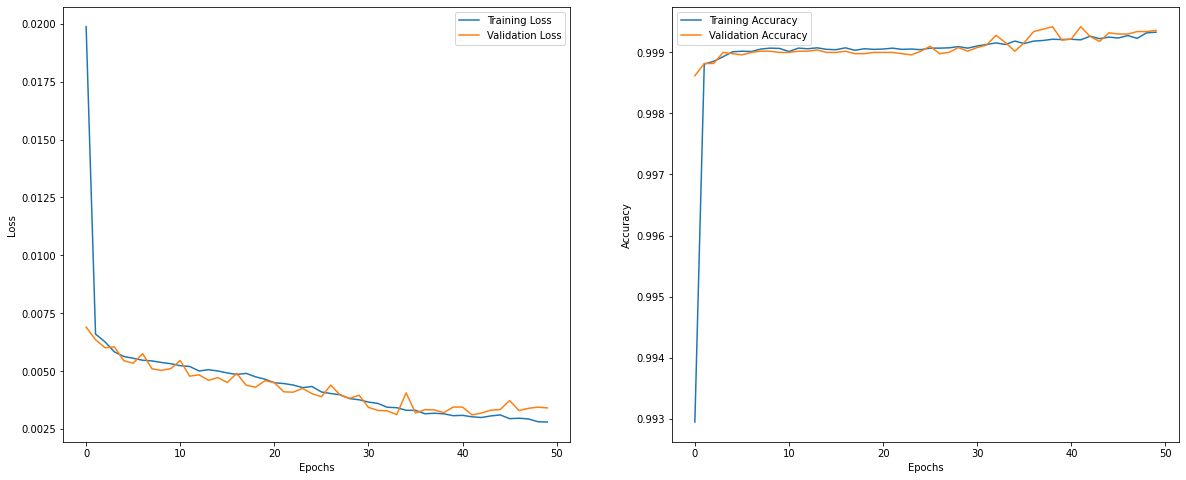

In [63]:
plot_curve(hist)

In [64]:
# Evaluate against the test set.
print("\n Evaluate the new model on the test set:")
result = model_classification.evaluate(x=x_test_final, y=y_test, batch_size=batch_size)

for item in zip(model_classification.metrics_names, result):
    print (item[0], np.round(item[1], 3))


 Evaluate the new model on the test set:
743/743 [==============================] - 1s 2ms/step - loss: 0.0111 - accuracy: 0.9986
loss 0.011
accuracy 0.999


In [65]:
model_classification.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                1952      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


# Create a deeper neural net model

In [66]:
def create_model_deep(my_learning_rate):
  # initial ANN
  model = Sequential()

# layers
  model.add(Dense(units = 32,  activation = 'relu', input_dim = 60))
  model.add(Dense(units = 32,  activation = 'relu'))
  model.add(Dense(units = 16,  activation = 'relu'))
  model.add(Dense(units = 8,  activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  opt = Adam(learning_rate= my_learning_rate)
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model   

In [67]:
learning_rate=0.01
number_epochs = 50
batch_size = 256
model_deep = create_model_deep(learning_rate)

hist1 = train_model(model_deep, number_epochs, batch_size )

Epoch 1/50
779/779 [==============================] - 4s 4ms/step - loss: 0.0440 - accuracy: 0.9869 - val_loss: 0.0061 - val_accuracy: 0.9988
Epoch 2/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.0067 - val_accuracy: 0.9989
Epoch 3/50
779/779 [==============================] - 3s 4ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0089 - val_accuracy: 0.9988
Epoch 4/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 0.0064 - val_accuracy: 0.9989
Epoch 5/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0054 - val_accuracy: 0.9990
Epoch 6/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0059 - val_accuracy: 0.9990
Epoch 7/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0054 - val_accuracy: 0.9990
Epoch 

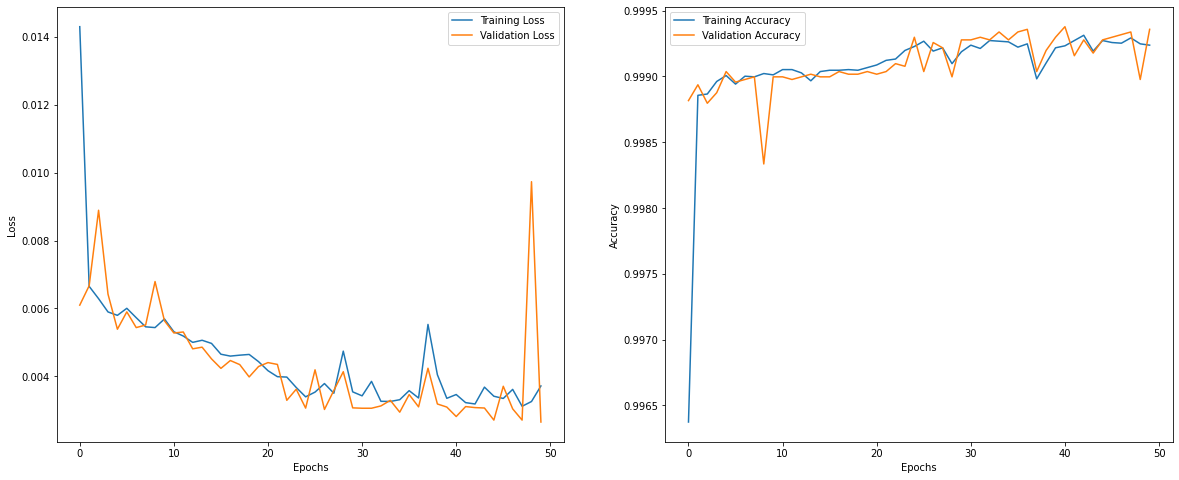

In [68]:
plot_curve(hist1)

In [69]:
model_deep.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                1952      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Evaluate against the test set.
print("\n Evaluate the new model on the test set:")
result = model_deep.evaluate(x=x_test_final, y=y_test, batch_size=batch_size)

for item in zip(model_deep.metrics_names, result):
    print (item[0], np.round(item[1], 3))


 Evaluate the new model on the test set:
743/743 [==============================] - 2s 2ms/step - loss: 0.5303 - accuracy: 0.9195
loss 0.53
accuracy 0.92


# Compare two models

In [71]:
history_df = pd.DataFrame(hist.history)


In [72]:
history1_df = pd.DataFrame(hist1.history)

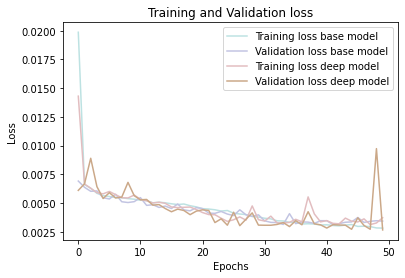

<Figure size 720x576 with 0 Axes>

In [73]:
#need to add the deep model line
plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss base model')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss base model')
plt.plot(history1_df.loc[:, ['loss']], "#e2bdc0", label='Training loss deep model')
plt.plot(history1_df.loc[:, ['val_loss']],"#cba888", label='Validation loss deep model')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.figure(figsize=(10, 8))
plt.show()

# Dropout Regularization

Notice that the model's loss against the test set is *higher* than the loss against the training set.  In other words, the deep neural network is *overfitting* to the data in the training set.  To reduce overfitting, regularize the model.

In [74]:
# Use Dropout Regularization
def create_model_deep_drop(my_learning_rate):
  # initial ANN
  model = Sequential()

# layers
  model.add(Dense(units = 32,  activation = 'relu', input_dim = 60))
  model.add(Dense(units = 32,  activation = 'relu'))
  model.add(Dense(units = 16,  activation = 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(units = 8,  activation = 'relu'))  
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  opt = Adam(learning_rate= my_learning_rate)
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model   

In [75]:
def train_model(model, epochs, batch_size):
  history= model.fit(
      x=x_final,
      y=y,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_split=0.2,
      shuffle= True,
      workers=4,
      use_multiprocessing=True
  )
  return history

In [76]:
learning_rate=0.01
epochs = 50
batch_size = 256


my_model = create_model_deep_drop(learning_rate)

#train the model
hist = train_model(my_model, epochs, batch_size)

Epoch 1/50
779/779 [==============================] - 4s 4ms/step - loss: 0.0790 - accuracy: 0.9756 - val_loss: 0.0095 - val_accuracy: 0.9986
Epoch 2/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0122 - accuracy: 0.9985 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 3/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0096 - accuracy: 0.9988 - val_loss: 0.0074 - val_accuracy: 0.9989
Epoch 4/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0061 - val_accuracy: 0.9990
Epoch 5/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9990
Epoch 6/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0084 - accuracy: 0.9986 - val_loss: 0.0061 - val_accuracy: 0.9990
Epoch 7/50
779/779 [==============================] - 3s 3ms/step - loss: 0.0088 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 

In [77]:
def plot_curve(hist):
    

    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

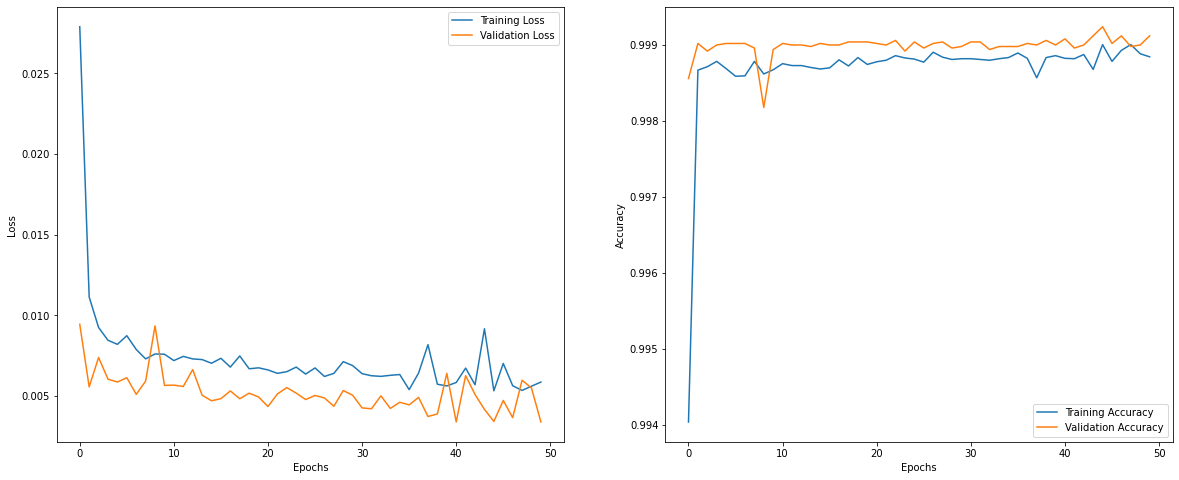

In [78]:
plot_curve(hist)

In [79]:
# Evaluate against the test set.
print("\n Evaluate the new model on the test set:")
result = my_model.evaluate(x=x_test_final, y=y_test, batch_size=batch_size)

for item in zip(my_model.metrics_names, result):
    print (item[0], np.round(item[1], 3))


 Evaluate the new model on the test set:
743/743 [==============================] - 2s 2ms/step - loss: 0.0283 - accuracy: 0.9986
loss 0.028
accuracy 0.999


In [80]:
y_pred= my_model.predict(x_test_final)
y_pred = (y_pred> 0.5)

In [81]:
test['Label'].value_counts()

1    133868
0     56306
Name: Label, dtype: int64

In [82]:
from sklearn import metrics

In [83]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro')

0.9978637932961181

In [84]:
DrDoS_report = f"""
Confusion Matrix:
{metrics.confusion_matrix(y_test, y_pred)}
"""
print(DrDoS_report)


Confusion Matrix:
[[ 56081    225]
 [    37 133831]]



In [85]:
train['Label'].value_counts()

1    215192
0     34036
Name: Label, dtype: int64

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56306
           1       1.00      1.00      1.00    133868

    accuracy                           1.00    190174
   macro avg       1.00      1.00      1.00    190174
weighted avg       1.00      1.00      1.00    190174

